In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

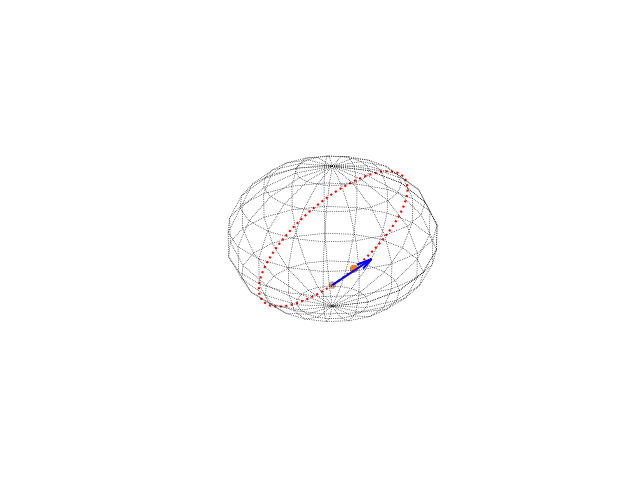

interactive(children=(FloatSlider(value=4.71238898038469, description='theta1', max=6.283185307179586), FloatS…

In [86]:
%matplotlib widget


# def spherical_to_cartesian(theta, phi):
def spherical_to_cartesian(s: np.ndarray):
    theta, phi = s[..., 0], s[..., 1]

    x = np.cos(theta) * np.sin(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(phi)
    return np.stack([x, y, z], axis=-1)


def great_circle(p1: np.ndarray, p2: np.ndarray, t: np.ndarray, r: float):
    u = p1 / r
    w = np.cross(p1, p2)
    v = np.cross(u, w) / np.linalg.norm(w)

    t = t[:, None]
    u = u[None, :]
    v = v[None, :]

    c = r * (u * np.cos(t) + v * np.sin(t))
    return c


def heading_angle(s1: np.ndarray, s2: np.ndarray):
    theta1, phi1 = s1
    theta2, phi2 = s2

    lon1, lon2 = theta1, theta2
    lat1, lat2 = np.pi / 2 - phi1, np.pi / 2 - phi2

    dl = lon2 - lon1
    y2 = np.sin(dl) * np.cos(lat2)
    wy = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dl)
    alpha = np.arctan2(y2, wy)
    return alpha


def heading_vector(p1: np.ndarray, h: float):
    """Meridian vector (phi_hat) at p1 rotated by h"""
    h = h + 3 * np.pi / 2
    theta, phi = p1
    theta_hat = np.array(
        [
            -np.sin(theta),
            np.cos(theta),
            0,
        ]
    )
    phi_hat = np.array(
        [
            np.cos(theta) * np.cos(phi),
            np.sin(theta) * np.cos(phi),
            -np.sin(phi),
        ]
    )
    return np.cos(h) * theta_hat + np.sin(h) * phi_hat


fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.axis("off")
# view straight from the y axis
ax.view_init(26, 270)

# sphere wireframe black dotted
theta, phi = np.linspace(0, 2 * np.pi, 20), np.linspace(0, np.pi, 10)
theta, phi = np.meshgrid(theta, phi)
x = spherical_to_cartesian(np.stack([theta, phi], axis=-1))
sphere_plot = ax.plot_wireframe(
    x[..., 0], x[..., 1], x[..., 2], color="k", linestyle=":", linewidth=0.5
)
# add labels
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")


points_scatter = []
initial = np.array(
    [
        [6 * np.pi / 4, np.pi / 2],
        [6 * np.pi / 4 + 0.2, np.pi / 2 - 0.2],
    ]
)
initial_cartesian = spherical_to_cartesian(initial)
for s in initial:
    points_scatter.append(
        ax.scatter(
            initial_cartesian[:, 0], initial_cartesian[:, 1], initial_cartesian[:, 2]
        )
    )

# draw great circle
t = np.linspace(0, 2 * np.pi, 100)
c = great_circle(initial_cartesian[0], initial_cartesian[1], t, 1)
circle_plot = ax.plot(c[:, 0], c[:, 1], c[:, 2], c="r", linestyle=":")[0]

# draw heading as quiver
h = heading_angle(initial[0], initial[1])
hv = heading_vector(initial[0], h)


def create_quiver_plot(p: np.ndarray, hv: np.ndarray):
    return ax.quiver(
        p[0],
        p[1],
        p[2],
        hv[0],
        hv[1],
        hv[2],
        color="b",
        length=0.5,
    )


hv_plot = create_quiver_plot(initial_cartesian[0], hv)

plt.show()


@widgets.interact(
    theta1=widgets.FloatSlider(min=0, max=2 * np.pi, step=0.1, value=initial[0][0]),
    phi1=widgets.FloatSlider(min=0, max=np.pi, step=0.1, value=initial[0][1]),
    theta2=widgets.FloatSlider(min=0, max=2 * np.pi, step=0.1, value=initial[1][0]),
    phi2=widgets.FloatSlider(min=0, max=np.pi, step=0.1, value=initial[1][1]),
)
def animate(theta1, phi1, theta2, phi2):
    global hv_plot

    # phi = np.mod(phi, 2 * np.pi)
    points = np.array([[theta1, phi1], [theta2, phi2]])
    x = spherical_to_cartesian(points)
    for i, point_scatter in enumerate(points_scatter):
        # update points
        xi = x[None, i]
        point_scatter._offsets3d = (xi[:, 0], xi[:, 1], xi[:, 2])
        ax.draw_artist(point_scatter)

        theta, phi = s
        phi_hat = np.array(
            [
                np.cos(theta) * np.cos(phi),
                np.sin(theta) * np.cos(phi),
                -np.sin(phi),
            ]
        )
        theta_hat = np.array(
            [
                -np.sin(theta),
                np.cos(theta),
                0,
            ]
        )

        # print(f"phi_hat: {phi_hat}")
        # print(f"theta_hat: {theta_hat}")

    c = great_circle(x[0], x[1], t, 1)
    circle_plot._verts3d = (c[:, 0], c[:, 1], c[:, 2])
    ax.draw_artist(circle_plot)

    # update heading
    hv_plot.remove()
    h = heading_angle(points[0], points[1])
    hv = heading_vector(points[0], h)
    hv_plot = create_quiver_plot(x[0], hv)
    ax.draw_artist(hv_plot)
    print(f"heading: {h}")

In [45]:
h = heading_angle(initial[0], initial[1])

In [48]:
np.pi / 2

1.5707963267948966